## Law of Large Numbers - Feller

Feller's "An Introduction to Probability Theory" volume one does a phenomenal job with the exposition of probability and especially how he develops the law of large numbers which I unpack below (the law discussed by Feller is the one proposed by Bernoulli but I'll discuss the broader version in a separate notebook). 

### Binomial Distribution
The binomial distribution simply represents a succession of $n$ Bernoulli trial where we only care about the cumulative figure of successes. As we don't care about order, the number of possible paths for $k$ total successes generated is $\binom{n}{k}$. Each path can happen with probability $p^kq^{n-k}$ as we simply multiply the individual trials which result in success with probability $p$ and failure with probability $q=1-p$. Let us get a taste of the distribution by varying the parameters and looking at the resulting probabilities. 

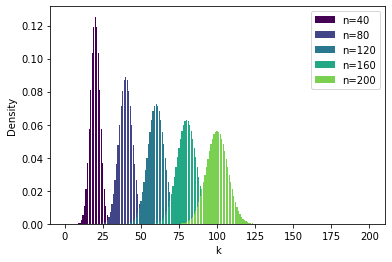

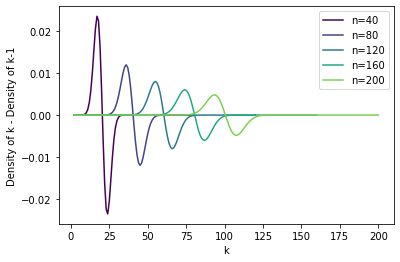

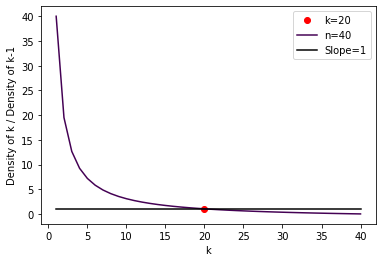

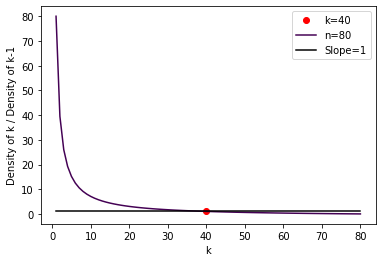

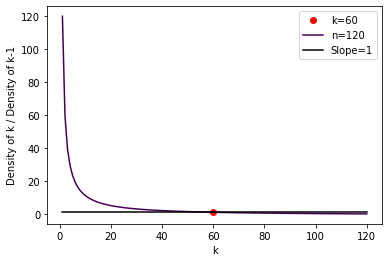

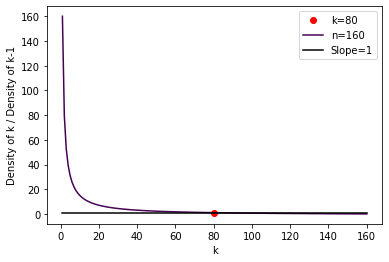

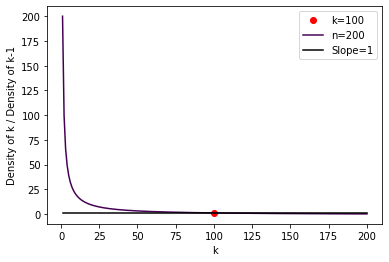

In [120]:
import matplotlib.pyplot as plt
import numpy as np
from math import comb


plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, 6)))
def binom_sim(p, n_start, n_stop, n_skip):
    """
    Description: Density plots where we vary n, fixing p
    :param: p: float in (0, 1], probability of success
    :param: n_start: int, starting number of trials
    :param: n_stop: int, ending number of trials
    :param: n_skip: int in (0, n_stop-n_start), skip x trials
    :return: plot of distribution where we vary n,
             plot of differenced distributions,
             plot of distribution slopes 
    """
    dists = []
    trials = [n for n in range(n_start, n_stop+1, n_skip)]
    for n in trials:
        dist = []
        for i in np.arange(1, n+1):
            density = comb(n, i) * p ** i * (1-p) ** (n-i)
            dist.append(density)

        plt.bar(np.arange(1, n+1), dist, label=f'n={n}')  
        dists.append(dist)
  
    plt.xlabel('k')
    plt.ylabel('Density')
    plt.legend()
    plt.show()  

    # plotting the slopes of the densities with respect to k
    for i in range(len(trials)):
        n = trials[i]
        dist = dists[i]
        diff_density = []
        for i in range(1, len(dist)):
            diff_density.append(dist[i] - dist[i - 1])

        plt.plot(np.arange(2, n+1), diff_density, label=f'n={n}')

    plt.xlabel('k')
    plt.ylabel('Density of k - Density of k-1')
    plt.legend()
    plt.show()
    
    # plotting the series divided by the prior term (density of k / density of k-1)
    div_densities = []
    for i in range(len(trials)):
        n = trials[i]
        div_density = []
        for i in range(1, n+1):
            div_term = ((n-i+1) * p) / (i * (1-p))
            div_density.append(div_term)
              
        intersection = np.argwhere(np.diff(np.sign(np.ones(len(div_density)) - div_density))).flatten()
        plt.plot(np.arange(1, len(div_density)+1)[intersection], np.array(div_density)[intersection], 'ro', label=f'k={np.arange(1, len(div_density)+1)[intersection][0]}')
        plt.plot(np.arange(1, len(div_density)+1), div_density, label=f'n={n}') 
        plt.plot(np.arange(1, len(div_density)+1), np.ones(len(div_density)), label='Slope=1', color='0')       
        plt.xlabel('k')
        plt.ylabel('Density of k / Density of k-1')
        plt.legend()
        plt.show()
    
    
binom_sim(0.5, 40, 200, 40)    

The plots reveals many interesting patterns and points to make about the binomial distribution. 

- First is the value of $k$ corresponding to the max density which increases with $n$. This can be checked by noting that for $X\sim Bin(n,p)$, we have $$\mathbb{E}[X]=\sum\limits_{i=0}^n i*\binom{n}{i}p^i(1-p)^{n-i}=np\sum\limits_{i=0}^n \binom{n-1}{i-1}p^{i-1}(1-p)^{n-i}$$ $$=np\sum\limits_{i=1}^n \binom{n-1}{i-1}p^{i-1}(1-p)^{n-i} = np\sum\limits_{j=0}^{n-1} \binom{n-1}{j}p^j(1-p)^{n-j}=np[p+(1-p)]^{n-1}=np$$ where we just subbed $j=i-1$ and utilized the power of the binomial theorem to arrive at $np$. 

- Second is the variance of the distribution which fans with respect to $n$. To check this, we can perform similar perfunctory steps as above to show the $\mathbb{V}(X)=np(1-p)$ which affirms that the variance increases as $n$ does. 

- Third is with respect to the second plot. We see that the slope of the distribution with respect to $k$ is concave where the slope peaks nearly around the point $np$. To check this, I also plotted the series divided by the prior value and include when the plot crosses one. When $k$ increases, the earlier probabilities start to get larger than the earlier ones and we see this red dot which represents when that starts to occur. 

To find exactly where the probabilities are increasing and decreasing, we can check: $$\frac{b(k; n, p)}{b(k-1; n, p)}=\frac{(n-k+1)p}{kq}=1+\frac{(n+1)p-k}{kq}.$$ This is greater than one if $$\frac{(n+1)p-k}{kq}>0\iff (n+1)p>k.$$ The two probabilities are equal (no unique maximum) if $(n+1)p=k$ and $k\in\mathbb{N}$ (if it's not a natural, the binomial distribution doesn't make sense). If $(n+1)p\notin\mathbb{N}$, then we can find the closest integer $x$ for when it crosses over: $$\frac{(n+1)p-k}{kq}\geq 0\iff (n+1)p-1<k\leq (n+1)p.$$ This term is the mode or as Feller says, the "central term" or "most probable number of successes". Determining the rate at which probabilities are increasing will prove helpful as we now transition to constructing the Law of Large Numbers.



### Law of Large Numbers (LLN)
The LLN characterizes how we intuitively expect probabilities to behave - if we take $n$ identical trials and the event $A$ occurs $m$ times, then $m/n$ should be approximately the probability of $A$ occuring in one trial. To make this point rigorous, mathematicians constructed the law of large numbers which was first proved by Bernoulli albiet the theorem was developed by Cardano earlier. Let the $n$ identical trials represent Bernoulli trials with probability $p$ for success. If $S_n$ is the sum of successes in $n$ trials, then $S_n/n$ represents the average number of successes. This should be close to $p$ - for more precise formation, we want to show that $P(S_n/n>p+\epsilon)\rightarrow 0$ and $P(S_n/n<p-\epsilon)\rightarrow 0$. Now how do we estimate these probabilities and prove convergence of $S/n$ to $p$ as $n$ grows? Well $$P(S_n/n>p+\epsilon)=P(S_n>n(p+\epsilon)=\sum\limits_{k=0}^\infty b(n(p+\epsilon)+k;n,p)$$ $$=\sum\limits_{k=0}^{n-n(p+\epsilon)} b(n(p+\epsilon)+k;n,p).$$ From here note that since $n(p+\epsilon)>np$, $b(n(p+\epsilon)+k)$ is monotonically decreasing as $k$ increases. This implies $$\exists\;x<1:x\cdot b(n(p+\epsilon)+k-1)=b(n(p+\epsilon)+k)$$ and the upper bound for $x$  as $n(p+\epsilon)>np$ is simply $$x=\frac{(n-n(p+\epsilon)+1)p}{n(p+\epsilon)q}\geq \frac{(n-n(p+\epsilon))p}{n(p+\epsilon)q}\geq 1-\frac{n(p+\epsilon)-np}{n(p+\epsilon)q}.$$ Bounding our series by a geometric series with this ratio $x$ yields $$\sum\limits_{k=0}^{n-n(p+\epsilon)} b(n(p+\epsilon)+k;n,p)\leq b(n(p+\epsilon);n,p)\sum\limits_{m=0}^\infty (1-\frac{n(p+\epsilon)-np}{n(p+\epsilon)q})^m=b(n(p+\epsilon);n,p)\frac{n(p+\epsilon)q}{n(p+\epsilon)-np}=b(n(p+\epsilon);n,p)\frac{(p+\epsilon)q}{\epsilon}.$$ Now, we need to find a suitable bound for the binomial probability $b(n(p+\epsilon); n,p)$. Since $np\leq k\leq n(p+\epsilon)$, there are at least $n\epsilon$ integer successes between. Then, we see clearly that $$1\geq \sum\limits_{k=np}^{n(p+\epsilon)} b(k; n, p)\geq n\epsilon\cdot b(n(p+\epsilon); n,p)\iff b(n(p+\epsilon); n, p)\leq \frac{1}{n\epsilon}.$$ Integrating this bound into our existing bound for the probability of at least $n(p+\epsilon)$ successes yields: $$\frac{(p+\epsilon)q}{n\epsilon^2}.$$ Thus as $n\rightarrow\infty$, we get that $P(S_n>n(p+\epsilon))\leq \frac{1}{n\epsilon^2}\rightarrow 0$. As $P(S_n<n(p-\epsilon))$ is simply the probability of at least $n-r$ failures, we end up with the same result for the lower bound and so in summation, we can say that $P(|\frac{S_n}{n}-p|<\epsilon)\rightarrow 1$. To see this convergence, let us analyze the convergence in some simulations below.

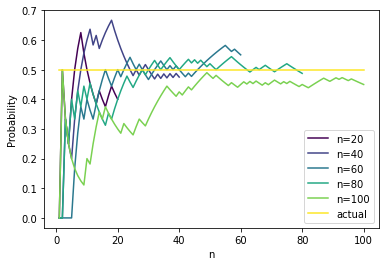

In [119]:
def lln_sim(p, n_start, n_stop, n_skip):
    """
    Description: Simulates the weak LLN in n trials
    :param: p: float in (0, 1], probability of success
    :param: n_start: int, starting number of trials
    :param: n_stop: int, ending number of trials
    :param: n_skip: int in (0, n_stop-n_start), skip x trials    
    """
    trials = [n for n in range(n_start, n_stop+1, n_skip)]
    trial_successes = []
    for n in trials:
        events = []
        for i in range(0, n):
            if np.random.rand() <= p:
                events.append(1)
            else:
                events.append(0)
                
        cum_avg_successes = []
        for i in range(0, n):
            avg_success = sum(events[:i]) / (i+1)
            cum_avg_successes.append(avg_success)
            
        plt.plot(np.arange(1, n+1), cum_avg_successes, label=f'n={n}')
        
    plt.plot(np.arange(1, n+1), [p for i in range(max(trials))], label='actual')
    plt.xlabel('n')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()      

    
lln_sim(0.5, 20, 100, 20)

As Feller also notes - there is a common misunderstanding of the theorem. Notably if we take two players where one bets heads and the other tails until say 100 successes, then the LLN is not saying that on average the two players would be leading the race to 100 roughly the same amount of trials. Instead, the law tells us that for fixed trials, we'd expect them to win roughly the same number of times. That's all I have to say about this particular limit theorem.